# Desafio final

Este projeto tem como objetivo realizar uma análise abrangente do consumo de energia elétrica no Brasil, utilizando dados de 2004 a 2023. O desafio consiste em explorar padrões de consumo energético, identificar tendências ao longo do tempo e investigar possíveis correlações com fatores socioeconômicos e geográficos. Através de técnicas de análise exploratória de dados e visualizações informativas, buscaremos compreender as variações no consumo entre diferentes estados, regiões e tipos de consumidores. Além disso, examinaremos a influência de fatores como população e desenvolvimento econômico no consumo de energia. Esta análise visa fornecer insights valiosos sobre o panorama energético brasileiro, contribuindo para uma compreensão mais profunda dos padrões de consumo e potencialmente auxiliando na formulação de políticas energéticas mais eficientes e sustentáveis. Para transparência, esse desafio foi feito de forma colaborativa com inteligência artificial em questões de estrutura e estilos claros e concisos da linguagem Python, buscando sempre que possível o pep-8.

In [20]:
# para começar com o pé direito
print('Hello, world!')

Hello, world!


## Estrutura de arquivos

Antes de mergulharmos na análise do consumo energético brasileiro, é crucial estabelecer uma base sólida para nosso projeto. Uma estrutura organizada e um sistema de versionamento eficiente são fundamentais para garantir a integridade e reprodutibilidade do nosso trabalho.

Para este projeto, adotei a seguinte estrutura de diretórios:

![Estrutura de diretórios e arquivos](../imagens/estrutura_inicio.png)

Esta organização permite uma clara separação entre dados brutos, processados e o código de análise, facilitando a navegação e manutenção do projeto.

Além disso, utilizo o GitHub para controle de versão, o que não só previne perdas acidentais, mas também abre portas para colaborações futuras. Um arquivo `.gitignore` foi configurado para excluir a pasta do ambiente virtual do versionamento, mantendo nosso repositório enxuto e focado apenas nos elementos essenciais do projeto.

Com esta base estabelecida, estamos prontos para iniciar nossa análise do consumo energético no Brasil, assegurando que nosso trabalho seja organizado, rastreável e colaborativo.

## Bibliotecas usadas

In [21]:
# análise e manipulação de dataframes
import pandas as pd
# geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# formatação numérica
import locale

## Preparação

### Criação dos dataframes iniciais

Para importar os dataframes, vamos dar uma breve olhada nos arquivos. Para isso vou abrir o arquivo csv no próprio VS Code, para saber qual é o separador:

![visualização do arquivo csv](../imagens/qual_separador.png)

Podemos ver que o separador é vírgula e que há arquivos ausentes já que tem duas vígulas na sequencia nos primeiros dados.

Agora usando a extensão DataWrangler:

![Visualização do CSV pelo DataWangler](../imagens/entendo_dataset_dw.png)

Podemos ver que em consumidores temos quase 1/3 de dados ausentes (Antes de verificarmos dados duplicados), isso é importante na nossa análise, voltaremos a isso logo mais.

### Importando os dados de energia elétrica

In [22]:
# importando o dataset de energia com o seperador por vírgulas
dataset_energia =  pd.read_csv('../dados/brutos/consumo_energia_eletrica.csv', sep=',', encoding='utf-8')

### Análise de dados duplicados para energia elétrica

Vamos verificar se temos dados duplicados, podemos usar duplicated().sum() e obter a quantidade, mas é interessantes podemos olhar de perto essas duplicatas e termos a certeza de que de fato são duplicatas. Minha abordagem será colocar esses valores em sequência, o dado original seguido do dado duplicado, mas como podem ser muitos dados, vamos adicionar um parâmetro para a escolha de visualização resumida ou completa.

In [23]:
import pandas as pd

def identifica_duplicatas(dataframe, resumido=True):
    """
    Identifica e exibe as linhas duplicadas em um DataFrame.
    
    Args:
    dataframe (pd.DataFrame): O DataFrame a ser analisado.
    resumido (bool): Se True, exibe um resumo padrão. Se False, exibe todas as linhas duplicadas agrupadas.
    
    Returns:
    pd.DataFrame: DataFrame contendo as linhas duplicadas.
    """
    # Identificar todas as linhas duplicadas
    duplicados = dataframe[dataframe.duplicated(keep=False)]

    # Ordenar as duplicatas para agrupar as linhas idênticas
    duplicados_ordenados = duplicados.sort_values(by=dataframe.columns.tolist())

    if resumido:
        # Exibir as duplicatas no formato resumido padrão do pandas
        quantidade_duplicados = dataframe.duplicated().sum()
        print(f'Foram encontradas {quantidade_duplicados} duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"')
        print("-" * 80)  # Linha separadora entre grupos
        print(duplicados_ordenados)
    else:
        # Configurar o pandas para mostrar todas as colunas
        with pd.option_context('display.max_columns', None, 'display.width', None):
            # Agrupar as duplicatas
            grupos = duplicados_ordenados.groupby(duplicados_ordenados.columns.tolist())
            
            for _, grupo in grupos:
                print("Grupo de linhas duplicadas:")
                for index, row in grupo.iterrows():
                    print(f"Linha {index}:")
                    print(row.to_frame().T)  # Transforma a Series em um DataFrame de uma linha
                print("-" * 80)  # Linha separadora entre grupos
                print()  # Linha em branco para melhor legibilidade



In [24]:
identifica_duplicatas(dataset_energia, True)

Foram encontradas 1017 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
37912  2023    1       AC    Comercial              23174.0    21629
38929  2023    1       AC    Comercial              23174.0    21629
38247  2023    1       AC   Industrial                299.0     3803
39264  2023    1       AC   Industrial                299.0     3803
38574  2023    1       AC  Residencial             240560.0    47887
...     ...  ...      ...          ...                  ...      ...
39550  2023   12       TO   Industrial               1413.0    35417
37888  2023   12       TO       Outros              53923.0    51090
38905  2023   12       TO       Outros              53923.0    51090
38856  2023   12       TO  Residencial             576079.0   119941
39873  2023   12       TO  Residencial             

Temos 1017 duplicatas, e a função mostram que realmente são dados duplicados. Vamos então limpar o dataset.

In [25]:
# removendo as duplicatas
dataset_energia.drop_duplicates(keep='first', inplace=True)

In [26]:
# vamos chamar a função novamente para ver se realmente foi efetivo
identifica_duplicatas(dataset_energia, True)

Foram encontradas 0 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [ano, mes, sigla_uf, tipo_consumo, numero_consumidores, consumo]
Index: []


### Criação de funções para detalhes em gráficos

In [27]:
# remove as bordas para uma estética minimalista
def remove_bordas():
  for spine in ax.spines.values():
    spine.set_visible(False)

In [28]:
# ajusta os ticks
def tick_params():
  ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
  ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

### Análise de dados ausentes para energia elétrica

Vamos criar uma função que verifica a quantidade de dados ausentes para as colunas desse dataframe, com base nos resultados que obtivermos, vamos decidir qual abordagem tomar.

In [29]:
def analise_dados_ausentes(df, crescente=False, tamanho_figura=(10, 6)):
    """
    Analisa e visualiza dados ausentes em um DataFrame.

    Args:
    df (pd.DataFrame): O DataFrame a ser analisado.
    crescente (bool): Se True, ordena do menor para o maior. Se False, do maior para o menor.
    tamanho_figura (tuple): Tamanho da figura do gráfico.

    Returns:
    None
    """
    # Calcular o número de valores ausentes por coluna
    valores_ausentes = df.isnull().sum().sort_values(ascending=crescente)
    
    # Calcular a porcentagem de valores ausentes
    porcentagens_ausentes = 100 * df.isnull().sum() / len(df)
    porcentagens_ausentes = porcentagens_ausentes.sort_values(ascending=crescente)

    # Criar o gráfico de barras horizontal
    plt.figure(figsize=tamanho_figura, facecolor='white')
    ax = valores_ausentes.plot(kind='barh', color='#4a4a4a')
    
    # Remover bordas
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Remover ticks do eixo y
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    
    # Adicionar valores
    for i, v in enumerate(valores_ausentes):
        ax.text(v, i, f' {v}', va='center')
    
    # Informações de títulos e rótulos
    plt.title('Quantidade de Dados Ausentes por Coluna', fontsize=14, pad=20)
    plt.xlabel('Número de Dados Ausentes', fontsize=12, labelpad=10)
    plt.ylabel('')  # Remover label do eixo y
    plt.tight_layout()
    plt.savefig('../imagens/quantidade_dados_ausentes.png', format='png', dpi=300)
    plt.show()

    # Imprimir as porcentagens de dados ausentes
    print("\nPorcentagem de Dados Ausentes por Coluna:")
    for col, porcentagem in porcentagens_ausentes.items():
        print(f"{col}: {porcentagem:.2f}%")

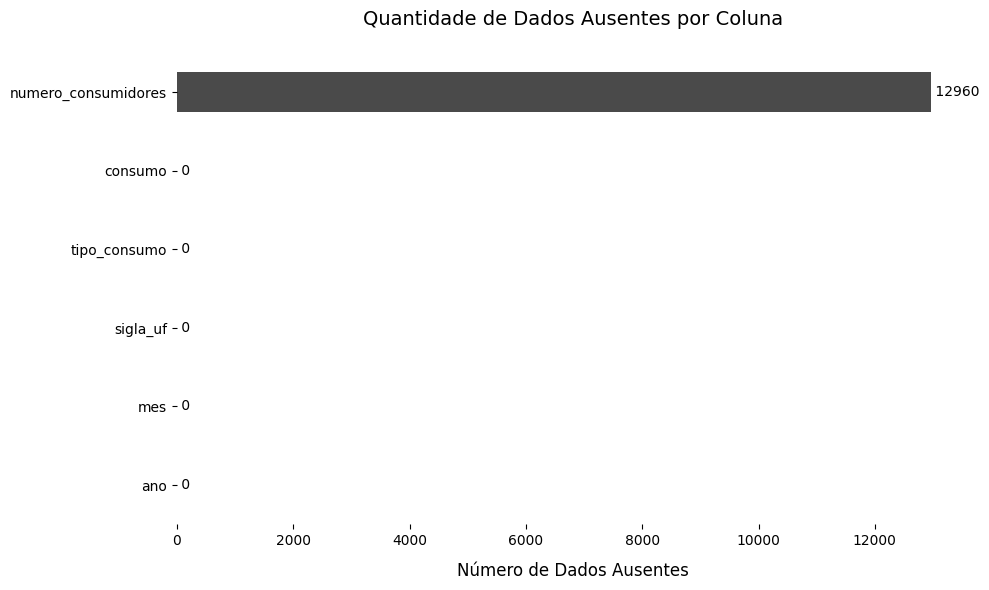


Porcentagem de Dados Ausentes por Coluna:
ano: 0.00%
mes: 0.00%
sigla_uf: 0.00%
tipo_consumo: 0.00%
consumo: 0.00%
numero_consumidores: 33.33%


In [30]:
analise_dados_ausentes(dataset_energia, True)

Temos 1/3 de dados ausentes na coluna "numero_consumidores", vamos analisar o comportamento desses dados ausentes, se é aleatório ou está concentrado.

In [31]:
filtro_ausente = dataset_energia['numero_consumidores'].isnull() == True

In [32]:
dataset_energia[filtro_ausente]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
37579,2023,12,DF,Cativo,NaN,503565
37580,2023,12,MT,Cativo,NaN,732101
37581,2023,12,RR,Cativo,NaN,112337
37582,2023,12,CE,Cativo,NaN,887204


In [33]:
dataset_energia[filtro_ausente].groupby('ano')['ano'].value_counts()

ano
2004    648
2005    648
2006    648
2007    648
2008    648
2009    648
2010    648
2011    648
2012    648
2013    648
2014    648
2015    648
2016    648
2017    648
2018    648
2019    648
2020    648
2021    648
2022    648
2023    648
Name: count, dtype: int64

Não há concentração de dados ausentes por ano. Cada ano tem exatamente o mesmo valor de dados ausentes. Vamos verificar outras variáveis, como "tipo_consumo".

In [34]:
tipos = dataset_energia['tipo_consumo'].unique()
for tipo in tipos:
  print(f'{tipo} = {len(dataset_energia[dataset_energia['tipo_consumo'] == tipo].value_counts())}')

Total = 0
Cativo = 0
Outros = 6480
Comercial = 6480
Industrial = 6480
Residencial = 6480


Total e Cativo não tem valores ao longo de todo o dataframe e eles compoõe os 12960 valores que faltam no dataframe.

Vamos tentar entender o funcionamento desses valores. Podemos inputar valores para Total uma vez que total é a soma de partes? Mas e o Cativo? 

In [35]:
filtro_ano1 = (dataset_energia['ano'] == 2004) & \
              (dataset_energia['sigla_uf'] == 'TO') & \
              (dataset_energia['mes'] == 2)
dataset_energia[filtro_ano1]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
52,2004,2,TO,Total,NaN,63306
356,2004,2,TO,Cativo,NaN,63306
698,2004,2,TO,Outros,22324.0,19893
1025,2004,2,TO,Comercial,26102.0,12160
1333,2004,2,TO,Industrial,2411.0,7267
1654,2004,2,TO,Residencial,233251.0,23986


Nessa amostra podemos perceber que o consumo dos tipos Residencial, Industrial, Comercial e Outros são equivalentes ao Total e que Cativo tem o mesmo valor de Total.

In [36]:
filtro_ano2 = (dataset_energia['ano'] == 2023) & \
              (dataset_energia['sigla_uf'] == 'SP') & \
              (dataset_energia['mes'] == 10)
dataset_energia[filtro_ano2]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
37200,2023,10,SP,Total,NaN,12212694
37509,2023,10,SP,Cativo,NaN,6979373
37849,2023,10,SP,Outros,384492.0,1306374
38158,2023,10,SP,Comercial,1176035.0,2669487
38489,2023,10,SP,Industrial,91621.0,4339535
38799,2023,10,SP,Residencial,19055719.0,3897297


Nessa outra amostra, novamente o consumo dos tipos Residencial, Industrial, Comercial e Outros equivale ao Total, e dessa vez Cativo não tem o mesmo valor, mas é um valor menor. Podemos deduzir que Cativo é uma representação especial que engloba os outros tipos de consumo? Vamos utilizar uma função para ver se é o caso para todo o dataframe.

In [37]:
def verificar_consumo(df, ano, mes, sigla_uf):
    """
    Verifica a consistência dos dados de consumo para um determinado ano, mês e UF.
    
    Args:
    df (pd.DataFrame): O DataFrame com os dados de consumo.
    ano (int): O ano a ser verificado.
    mes (int): O mês a ser verificado.
    sigla_uf (str): A sigla da UF a ser verificada.
    
    Returns:
    dict: Um dicionário com os resultados da verificação.
    """
    filtro = (df['ano'] == ano) & (df['mes'] == mes) & (df['sigla_uf'] == sigla_uf)
    dados_filtrados = df[filtro]
    
    total = dados_filtrados[dados_filtrados['tipo_consumo'] == 'Total']['consumo'].values[0]
    cativo = dados_filtrados[dados_filtrados['tipo_consumo'] == 'Cativo']['consumo'].values[0]
    
    tipos_especificos = ['Outros', 'Comercial', 'Industrial', 'Residencial']
    soma_especificos = dados_filtrados[dados_filtrados['tipo_consumo'].isin(tipos_especificos)]['consumo'].sum()
    
    soma_igual_total = abs(soma_especificos - total) < 1  # Tolerância de 1 unidade para evitar problemas de arredondamento
    cativo_menor_igual_total = cativo <= total
    
    return {
        'ano': ano,
        'mes': mes,
        'sigla_uf': sigla_uf,
        'total': total,
        'soma_especificos': soma_especificos,
        'cativo': cativo,
        'soma_igual_total': soma_igual_total,
        'cativo_menor_igual_total': cativo_menor_igual_total
    }

def verificar_todos_dados(df):
    resultados = []
    contador_soma_diferente = 0
    contador_cativo_maior = 0
    
    combinacoes = df[['ano', 'mes', 'sigla_uf']].drop_duplicates()
    
    for _, row in combinacoes.iterrows():
        resultado = verificar_consumo(df, row['ano'], row['mes'], row['sigla_uf'])
        
        if not resultado['soma_igual_total']:
            contador_soma_diferente += 1
            print(f"\nDiscrepância na soma (Total vs Específicos):")
            print(f"Ano: {resultado['ano']}, Mês: {resultado['mes']}, UF: {resultado['sigla_uf']}")
            print(f"Total: {resultado['total']}")
            print(f"Soma dos Específicos: {resultado['soma_especificos']}")
            print(f"Diferença: {abs(resultado['total'] - resultado['soma_especificos'])}")
        
        if not resultado['cativo_menor_igual_total']:
            contador_cativo_maior += 1
            print(f"\nCativo maior que Total:")
            print(f"Ano: {resultado['ano']}, Mês: {resultado['mes']}, UF: {resultado['sigla_uf']}")
            print(f"Total: {resultado['total']}")
            print(f"Cativo: {resultado['cativo']}")
            print(f"Diferença: {resultado['cativo'] - resultado['total']}")
        
        resultados.append(resultado)
    
    print(f"\nTotal de discrepâncias na soma: {contador_soma_diferente}")
    print(f"Total de casos onde Cativo > Total: {contador_cativo_maior}")
    
    return pd.DataFrame(resultados)

# Aplicar a verificação
df_resultados = verificar_todos_dados(dataset_energia)


Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: TO
Total: 65876
Soma dos Específicos: 65875
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: BA
Total: 1444451
Soma dos Específicos: 1444449
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: PR
Total: 1596274
Soma dos Específicos: 1596273
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RS
Total: 1780912
Soma dos Específicos: 1780910
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: SE
Total: 192207
Soma dos Específicos: 192205
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: MG
Total: 3732811
Soma dos Específicos: 3732810
Diferença: 1

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: MS
Total: 272917
Soma dos Específicos: 272915
Diferença: 2

Discrepância na soma (Total vs Específicos):
Ano: 2004, Mês: 1, UF: RJ
Total: 2612753
Soma dos Es

A função mostra que há diferenças entre as somas das partes (exceto Cativo) e o Total, mas que essa diferença é na maioria dos casos 1 ou 2 kW e que em três vezes que Cativo foi maior do que o Total a diferença foi de 1kW. Então podemos deduzir o que se mostra a seguir:

1. **Expressão do Consumo Total**:
   $$
   \text{Total} = Residencial + Industrial + Comercial + Outros
   $$

2. **Consumo Cativo como Parte do Total**:
   
   Podemos expressar que o consumo Cativo ($\text{Cativo}$) está contido no Total ($\text{Total}$) da seguinte maneira:
   $$
   \text{Cativo} \subseteq \text{Total}
   $$

3. **Definição Condicional do Consumo Cativo**:
   
   Ou seja:
   $$
   \text{Cativo} = \{ x \in \text{Total} \mid x \text{ representa um consumo que faz parte do regime cativo} \}
   $$


O que é Cativo?

O consumo cativo é um tipo de contratação de energia elétrica em que o consumidor é obrigado a comprar energia de uma concessionária local e pagar as tarifas estabelecidas pelo governo. 
No mercado cativo, o consumidor não pode negociar o preço da energia e está sujeito a cobranças extras, como as bandeiras tarifárias. As tarifas são reguladas pela Agência Nacional de Energia Elétrica (ANEEL) e são estabelecidas considerando os custos de geração, transmissão e distribuição. 
O consumidor cativo é um participante do Ambiente de Contratação Regulada (ACR), que é a forma tradicional de consumir energia no Brasil. A maioria dos consumidores comuns fazem parte do mercado cativo. 
O consumidor cativo pode pagar pela eletricidade por meio de tarifa monômia ou binômia, dependendo de sua classe de tensão. 
O consumidor cativo pode migrar para o mercado livre de energia, desde que comunique a mudança à distribuidora com, no mínimo, seis meses de antecedência.

Fontes: https://srna.co/consumidor-cativo-e-consumidor-livre-entenda-as-diferencas/ https://blog.esferaenergia.com.br/mercado-livre-de-energia/o-que-mercado-cativo-energia https://www.portalsolar.com.br/qual-a-diferenca-entre-consumidor-cativo-e-consumidor-livre-de-energia 

Com base nisso, não excluirei dados, mas segmentarei levando em consideração a ausência de dados em numero_consumidores para Cativos.

In [38]:
# criando uma coluna gWh gigaWatt-hora para ter números menores e mais fáceis de ler
dataset_energia['gWh'] = dataset_energia['consumo'] / 1_000_000

In [39]:
# criando o dataframe final
dataset_energia.to_csv('../dados/processados/df.csv')

In [40]:
df = dataset_energia.copy()

### importando a base de estados

Podemos observar, olhando o arquivo csv que não há dados duplicados, que o separador é ";", mas que temos problemas com o encoding.

![Visualização do CSV da base de estados](../imagens/base_estados.png)

In [41]:
# importando a base de estados usando encoding latin1 para a acentuação
df_estados = pd.read_csv('../dados/brutos/estado_regiao.csv', sep=';', encoding='latin1')

In [42]:
df_estados.head()

,id_estado,sigla,estado,regiao,pais
0,1,AC,Acre,Norte,Brasil
1,2,AL,Alagoas,Nordeste,Brasil
2,3,AP,Amapá,Norte,Brasil
3,4,AM,Amazonas,Norte,Brasil
4,5,BA,Bahia,Nordeste,Brasil


Vamos fazer duas intervenções nessa base, como a base de dados de energia usa sigla_uf para identificar os estados, não precisamos da coluna id_estado e como estamos trabalhando apenas com dados do Brasil, não precisamos da coluna país. Vamos então renomear a coluna sigla para sigla_uf e excluir id_estado e pais.

In [43]:
# removendo as colunas
df_estados.drop(['id_estado', 'pais'], axis=1, inplace=True)

# renomeando a coluna para o join
df_estados.rename(columns={'sigla': 'sigla_uf'}, inplace=True)


In [44]:
df_estados.head()

,sigla_uf,estado,regiao
0,AC,Acre,Norte
1,AL,Alagoas,Nordeste
2,AP,Amapá,Norte
3,AM,Amazonas,Norte
4,BA,Bahia,Nordeste


In [45]:
df_estados.to_csv('../dados/processados/df_estados.csv')

In [46]:
df

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,gWh
0,2004,1,TO,Total,NaN,65876,0.065876
1,2004,1,BA,Total,NaN,1444451,1.444451
2,2004,1,PR,Total,NaN,1596274,1.596274
3,2004,1,RS,Total,NaN,1780912,1.780912
4,2004,1,GO,Total,NaN,630624,0.630624
...,...,...,...,...,...,...,...
38875,2023,12,BA,Residencial,5932740.0,718461,0.718461
38876,2023,12,PA,Residencial,2614106.0,478726,0.478726
38877,2023,12,AC,Residencial,245699.0,58301,0.058301
38878,2023,12,RN,Residencial,1390080.0,210119,0.210119


### importando a população de 2000, 2010 e 2022

Os dados de população vieram do IBGE e de diferentes formas, então vamos tratar esses dados.

In [47]:
# importando a base para a população por estados dos anos 2000
pop_2000 = pd.read_excel('../dados/brutos/pop_2000.xls')
pop_2000.head(10)

,"Tabela 2 - População residente, por situação do domicílio e sexo,",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,segundo as Grandes Regiões e as Unidades da Fe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grandes Regiões\ne\nUnidades da Federação,"População residente, por situação do domicílio...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Total ...,NaN,NaN,Urbana ...,NaN,NaN,Rural ...,NaN,NaN
5,NaN,Total ...,Homens ...,Mulheres ...,Total ...,Homens ...,Mulheres ...,Total ...,Homens ...,Mulheres ...
6,Brasil,169799170,83576015,86223155,137953959,66882993,71070966,31845211,16693022,15152189
7,Norte,12900704,6533555,6367149,9014365,4441624,4572741,3886339,2091931,1794408
8,Rondônia,1379787,708140,671647,884523,439714,444809,495264,268426,226838
9,Acre,557526,280983,276543,370267,180190,190077,187259,100793,86466


In [48]:
# pegando a parte que interessa: estados e população
pop_2000 = pop_2000.iloc[6:-2,[0,1]].copy()
# renomeando as colunas
pop_2000.rename(columns={'Tabela 2 - População residente, por situação do domicílio e sexo, ':'estado',
                          'Unnamed: 1':'populacao'}, inplace=True)
# retirando as linhas com os dados por região, pois já temos no df_estados
pop_2000 = pop_2000[pop_2000['estado'].isin(df_estados['estado'])]
# resetando o index
pop_2000.reset_index(drop=True, inplace=True)
# convertendo o tipo da população para int
pop_2000['populacao'] = pop_2000['populacao'].astype(int)
# criando a variável com o total da população do Brasil
pop_2000_brasil = int(pop_2000['populacao'].sum())

In [106]:
identifica_duplicatas(pop_2000, resumido=True)

Foram encontradas 0 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [107]:
pop_2000.to_csv('../dados/processados/pop_2000.csv')

In [49]:
pop_2000.head()

,estado,populacao
0,Rondônia,1379787
1,Acre,557526
2,Amazonas,2812557
3,Roraima,324397
4,Pará,6192307


In [50]:
pop_2010 = pd.read_excel('../dados/brutos/pop_2010.xls')
pop_2010.head(10)

,Censo Demográfico 2010 - Resultados Gerais da Amostra,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"Tabela 1.2.1 - População residente, por nacion...",NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Grandes Regiões e Unidades da Federação,População residente,NaN,NaN,NaN,NaN
3,NaN,Total,Nacionalidade,NaN,NaN,NaN
4,NaN,NaN,Brasileira,NaN,NaN,Estrangeira
5,NaN,NaN,Total,Nata,Por naturalização,NaN
6,Brasil,190755799,190324479.672607,190163229.329875,161250.342732,431319.327393
7,Norte,15864454.0,15847999.325467,15838717.080313,9282.245154,16454.674533
8,Rondônia,1562409.0,1559687.35831,1557720.139,1967.219311,2721.64169
9,Acre,733559,732627.464974,732047.54461,579.920364,931.535026


In [51]:
# pegando a parte que interessa: estados e população
pop_2010 = pop_2010.iloc[6:-2,[0,1]]
# renomeando as colunas
pop_2010.rename(columns={'Censo Demográfico 2010 - Resultados Gerais da Amostra':'estado',
                          'Unnamed: 1':'populacao'}, inplace=True)
# retirando as linhas com os dados por região, pois já temos no df_estados
pop_2010 = pop_2010[pop_2010['estado'].isin(df_estados['estado'])]
# resetando o index
pop_2010.reset_index(drop=True, inplace=True)
# convertendo o tipo da população para int
pop_2010['populacao'] = pop_2010['populacao'].astype(int)
# criando a variável com o total da população do Brasil
pop_2010_brasil = int(pop_2010['populacao'].sum())

In [105]:
identifica_duplicatas(pop_2010, resumido=True)

Foram encontradas 0 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [108]:
pop_2010.to_csv('../dados/processados/pop_2010.csv')

In [52]:
pop_2010.head(5)

,estado,populacao
0,Rondônia,1562409
1,Acre,733559
2,Amazonas,3483985
3,Roraima,450479
4,Pará,7581050


In [53]:
# importando a base do censo de 2022
pop_2022 = pd.read_csv('../dados/brutos/Censo_2022_populacao.csv', sep=';', encoding='utf8')
# renomeando a coluna de estados e populacao
pop_2022.rename(columns={'Unidades da Federação': 'estado', 'pessoas':'populacao'}, inplace=True)
# criando a população total
pop_2022_brasil = int(pop_2022['populacao'].sum())

In [104]:
identifica_duplicatas(pop_2022, resumido=True)

Foram encontradas 0 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [estado, populacao]
Index: []


In [109]:
pop_2022.to_csv('../dados/processados/pop_2022.csv')

### Importando o IDHM entre 2012 e 2021

Fonte: https://www.undp.org/pt/brazil/desenvolvimento-humano/painel-idhm

In [127]:
idhm = pd.read_excel('../dados/brutos/idhm.xlsx')

In [128]:
# selecionando os dados que interessam
# ano, nome do estado e idhm
idhm = idhm.iloc[10:280,[0,3,4]].copy().reset_index(drop=True)

In [129]:
idhm.rename(columns={'ANO':'ano', 'NOME':'estado', 'IDHM':'idhm'}, inplace=True)

In [130]:
identifica_duplicatas(idhm, resumido=True)

Foram encontradas 0 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
Empty DataFrame
Columns: [ano, estado, idhm]
Index: []


In [131]:
idhm.to_csv('../dados/processados/idhm.csv')

In [135]:
idhm.sample(5)

,ano,estado,idhm
209,2019,Paraná,0.807
167,2018,Amapá,0.741
109,2016,Acre,0.723
171,2018,Ceará,0.739
212,2019,Mato Grosso do Sul,0.777


# Perguntas a serem respondidas

## 1. Qual foi o consumo máximo geral da série histórica (2004 - 2023)

In [54]:
# Guardando os anos iniciais e finais em variáveis
ano_comeco = df['ano'].min()
ano_fim = df['ano'].max()

# Criando a variável consumo total pelo agrupamento do Total
consumo_total = df.groupby('tipo_consumo')['gWh'].sum().loc['Total']

# Configurando o locale para português do Brasil para facilitar a leitura do número
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

consumo_formatado = locale.format_string('%.2f', consumo_total, grouping=True)

print(f'O Brasil consumiu {consumo_formatado} gWh, contando todos os estados entre {ano_comeco} e {ano_fim}')

O Brasil consumiu 8.791,31 gWh, contando todos os estados entre 2004 e 2023


## 2. Qual a evolução do consumo máximo geral anual da série histórica (2004 - 2023)

In [55]:
# Agrupamento por ano
consumo_anual_total = df[df['tipo_consumo'] == 'Total'].groupby('ano')['gWh'].sum()

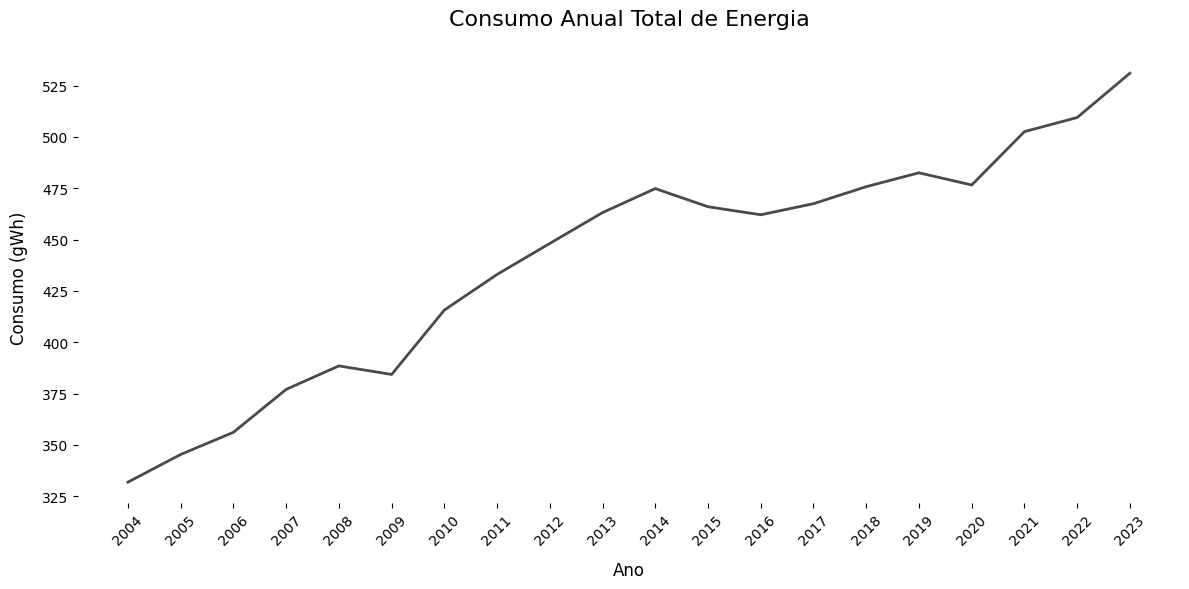

In [56]:
# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotar o lineplot
sns.lineplot(x=consumo_anual_total.index, y=consumo_anual_total.values, 
             color='#4a4a4a', linewidth=2, ax=ax)

# Remover bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Remover ticks do eixo y
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(2004, 2024))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Consumo Anual Total de Energia', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('Consumo (gWh)', fontsize=12, labelpad=10)

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig('../imagens/consumo_anual_total.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Alguns fatos que ocorreram nesses anos:

2004-2008: Crescimento Econômico e Expansão Industrial

2009: Crise Financeira Global

Maior apagão do Brasil em 2009: https://memoriaglobo.globo.com/jornalismo/jornalismo-e-telejornais/jornal-nacional/reportagens-e-entrevistas/noticia/apagao-no-brasil-em-2009.ghtml

2010-2014: Recuperação e Grandes Eventos como Copa do mundo.

2015-2016: Crise Econômica e Política e Olimpíadas em 2016

2017-2019: Recuperação Econômica Lenta

2020: Pandemia de COVID-19

2021-2023: Retomada e Sustentabilidade

## 3. Qual a evolução da base consumidora na série histórica (2004 - 2023)?

Vamos agrupar o número total de consumidores por estado ao longo da série histórica e depois plotar um gráfico de linha para mostrar essa evolução, assumimos que total é justamente a soma dos tipos de consumo e que cativo faz parte do total, mas não é uma categoria contabilizada

In [57]:
ano_inicial = 2004
ano_final = 2023

In [58]:
# Agrupamento por ano, pegando apenas dezembro de cada ano
consumidores_anuais = df[df['mes'] == 12].groupby('ano')['numero_consumidores'].sum()

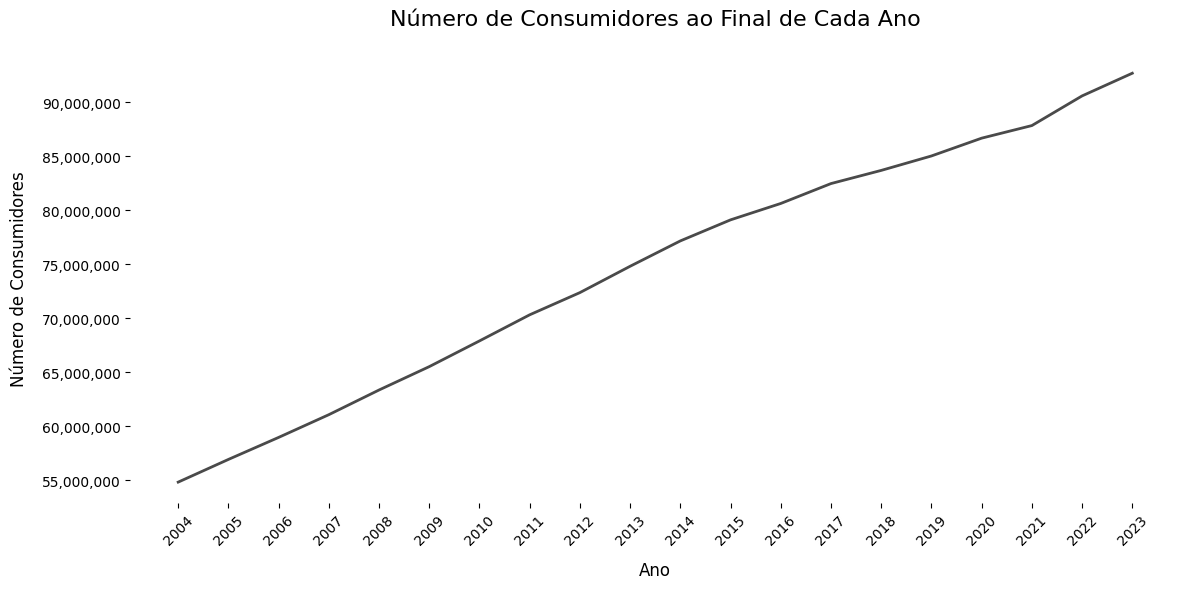

In [59]:
# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotar o lineplot
sns.lineplot(x=consumidores_anuais.index, y=consumidores_anuais.values, 
             color='#4a4a4a', linewidth=2, ax=ax)

# Remover bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Remover ticks do eixo y
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(ano_inicial, ano_final +1))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Número de Consumidores ao Final de Cada Ano', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('Número de Consumidores', fontsize=12, labelpad=10)

# Formatar o eixo y para usar separador de milhares
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig('../imagens/numero_consumidores_anual.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Como é o crescimento da base consumidora e da população geral?

In [60]:
# Dados do censo
anos_censo = [2000, 2010, 2022]
pop_censo = [pop_2000_brasil, pop_2010_brasil, pop_2022_brasil]

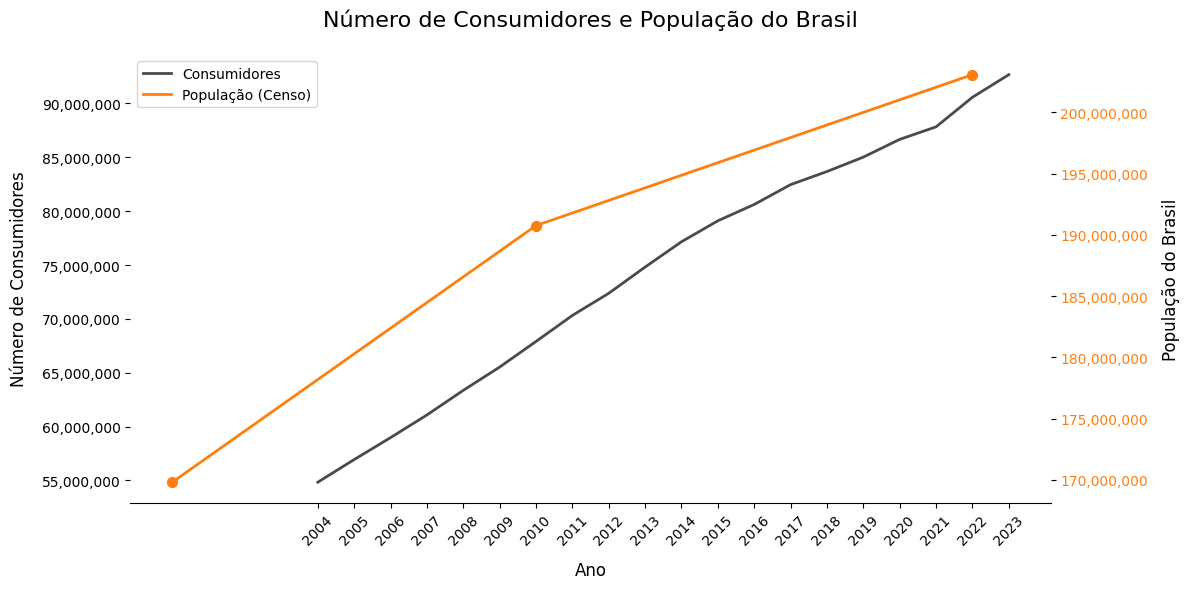

In [61]:
# Criar a figura e o eixo
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotar o lineplot dos consumidores
sns.lineplot(x=consumidores_anuais.index, y=consumidores_anuais.values, 
             color='#4a4a4a', linewidth=2, ax=ax1, label='Consumidores')

# Remover bordas
for spine in ax1.spines.values():
    spine.set_visible(False)

# Remover ticks do eixo y
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(ano_inicial, ano_final + 1))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Número de Consumidores e População do Brasil', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
ax1.set_ylabel('Número de Consumidores', fontsize=12, labelpad=10)

# Formatar o eixo y para usar separador de milhares
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Criar um segundo eixo y para a população
ax2 = ax1.twinx()

# Plotar a linha da população
ax2.plot(anos_censo, pop_censo, color='#ff7f0e', linewidth=2, label='População (Censo)')
ax2.scatter(anos_censo, pop_censo, color='#ff7f0e', s=50)

# Configurar o eixo y da população
ax2.set_ylabel('População do Brasil', fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Remover bordas do segundo eixo
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Adicionar legendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig('../imagens/numero_consumidores_e_populacao.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Esse gráfico trabalha com duas escalas e tem o intuito de comparar o crescimento da população geral e o de consumidores e podemos ver que a reta dos consumidores tem uma evolução mais vigorosa enquanto a população geral mostra uma desaceleração. É importante notar que para cada consumidor pode haver uma família de pessoas.

## 5. O quanto do consumo acumulado entre 2004 e 2023 é cativo em relação ao total?

Vamos voltar a esse assunto e entender como se comporta esse regime de contratos. Vamos agrupar por tipo de consumo a soma deles e dividir Cativo por Total.

In [62]:
# vamos agrupar por tipo de consumo e pegar o valor em Cativo
consumo_total_cativo = df.groupby('tipo_consumo')['gWh'].sum().loc['Cativo']

# obtendo a porcentagem do consumo cativo dividindo pelo consumo total
consumo_total_cativo_relativo = consumo_total_cativo / consumo_total * 100

print(f'O consumo cativo acumulado em comparação ao consumo acumulado total é {consumo_total_cativo_relativo:.2f}%')

O consumo cativo acumulado em comparação ao consumo acumulado total é 70.54%


## 6. Evolução do consumo cativo ao longo da série histórica (2004 - 2023)

Vamos agora obter o valor do consumo cativo a cada ano.

In [63]:
consumo_anual_cativo = df[df['tipo_consumo'] == 'Cativo'].groupby('ano')['gWh'].sum()
consumo_relativo_anual_cat_total = consumo_anual_cativo / consumo_anual_total * 100

In [64]:
# Criar um DataFrame combinando as duas séries
df_consumo = pd.DataFrame({
    'Cativo': consumo_anual_cativo,
    'Total': consumo_anual_total
})

In [65]:
# Calcular o consumo livre (diferença entre total e cativo)
df_consumo['Livre'] = df_consumo['Total'] - df_consumo['Cativo']

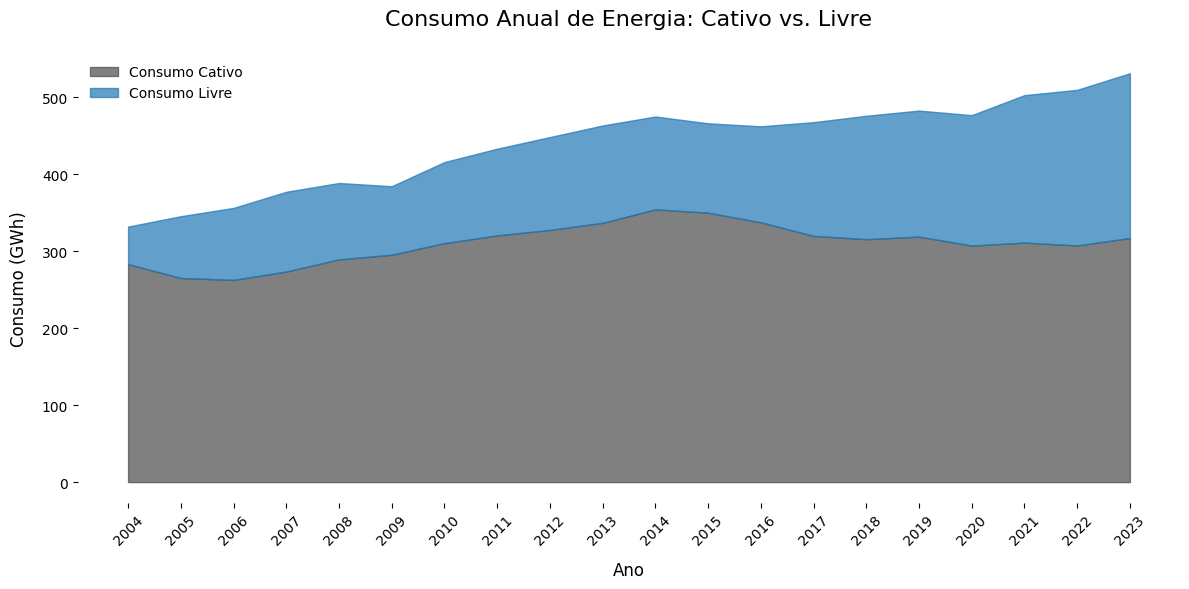

In [66]:
# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotar o gráfico de área
ax.fill_between(df_consumo.index, 0, df_consumo['Cativo'], alpha=0.7, color='#4a4a4a', label='Consumo Cativo')
ax.fill_between(df_consumo.index, df_consumo['Cativo'], df_consumo['Total'], alpha=0.7, color='#1f77b4', label='Consumo Livre')

# Remover bordas
remove_bordas()

# Configurar os ticks do eixo x
tick_params()

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(2004, 2024))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Consumo Anual de Energia: Cativo vs. Livre', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('Consumo (GWh)', fontsize=12, labelpad=10)

# Adicionar legenda
plt.legend(loc='upper left', frameon=False)

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig('../imagens/consumo_anual_cativo_livre.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Podemos notar que o consumo livre foi aumentando ao longo do tempo. 

## 7. Qual a evolução percentual do consumo livre de energia ao longo da série histórica?

Lembrando que o consumo livre é a diferença entre Total e Cativo.

In [67]:
# vamos criar um df para abrigar a diferença entre Total e Cativo e passar para porcentagem
livre_relativo = df_consumo['Livre'] / consumo_anual_total * 100

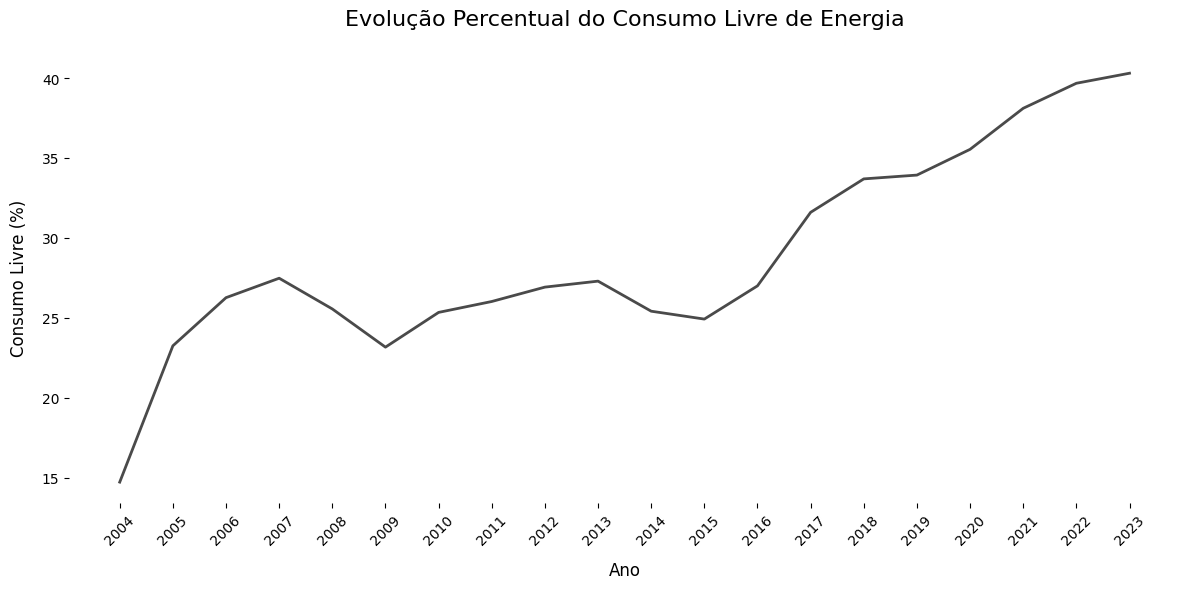

In [68]:
# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Plotar o lineplot
sns.lineplot(x=livre_relativo.index, y=livre_relativo.values, 
             color='#4a4a4a', linewidth=2, ax=ax)

# Remover bordas
for spine in ax.spines.values():
  spine.set_visible(False)

# Remover ticks do eixo y
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(2004, 2024))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Evolução Percentual do Consumo Livre de Energia', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('Consumo Livre (%)', fontsize=12, labelpad=10)

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig('../imagens/consumo_livre_percentual.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Há sazonalidade no consumo da série histórica (2004 - 2023)

In [69]:
def criar_lineplot_multifacetado(df, n_colunas=3):
    """
    Cria um gráfico de lineplots multifacetado por ano, mostrando a média mensal do consumo,
    com eixo y compartilhado começando em 0.4.

    Args:
    df (pd.DataFrame): O DataFrame com os dados de consumo.
    n_colunas (int): Número de colunas no grid de gráficos.

    Returns:
    None (exibe o gráfico)
    """
      
    # Calcular a média mensal para cada ano
    df_media = df[df['tipo_consumo'] == 'Total'].groupby(['ano', 'mes'])['gWh'].mean().reset_index()
        
    # Calcular o número de anos únicos e o número de linhas necessárias
    anos_unicos = sorted(df['ano'].unique())
    n_anos = len(anos_unicos)
    n_linhas = (n_anos + n_colunas - 1) // n_colunas

    # Configurar o estilo
    sns.set_style("white")

    # Criar a figura e os subplots com eixo y compartilhado
    fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(5*n_colunas, 3*n_linhas), 
                             squeeze=False, sharex=False, sharey=True)
    fig.suptitle('Média Mensal de Consumo por Ano', fontsize=16, y=1.02)

    # Encontrar os limites globais do eixo y
    y_min = df_media['gWh'].min() / 1.05
    y_max = df_media['gWh'].max() * 1.05 # 5% de margem no topo

    # Criar lineplots para cada ano
    for i, ano in enumerate(anos_unicos):
        ax = axes[i // n_colunas, i % n_colunas]
        dados_ano = df_media[df_media['ano'] == ano]
        
        sns.lineplot(x='mes', y='gWh', data=dados_ano, ax=ax,
                     color='#4a4a4a', marker='o', linewidth=2, markersize=6)
        
        ax.set_title(f'Ano {ano}', fontsize=12)
        ax.set_xlabel('')
        if i % n_colunas == 0:
            ax.set_ylabel('Consumo Médio (gWh)')
        else:
            ax.set_ylabel('')
        
        # Personalizar os ticks do eixo x
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], rotation=0)
        
        # Remover as bordas do gráfico
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Adicionar uma grade horizontal suave
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)

        # Ajustar os limites do eixo y
        ax.set_ylim(y_min, y_max)

    # Remover subplots vazios
    for i in range(n_anos, n_linhas * n_colunas):
        fig.delaxes(axes[i // n_colunas, i % n_colunas])

    # Ajustar o layout e exibir
    plt.tight_layout()
    plt.savefig('../imagens/consumo_medio_mensal_total.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

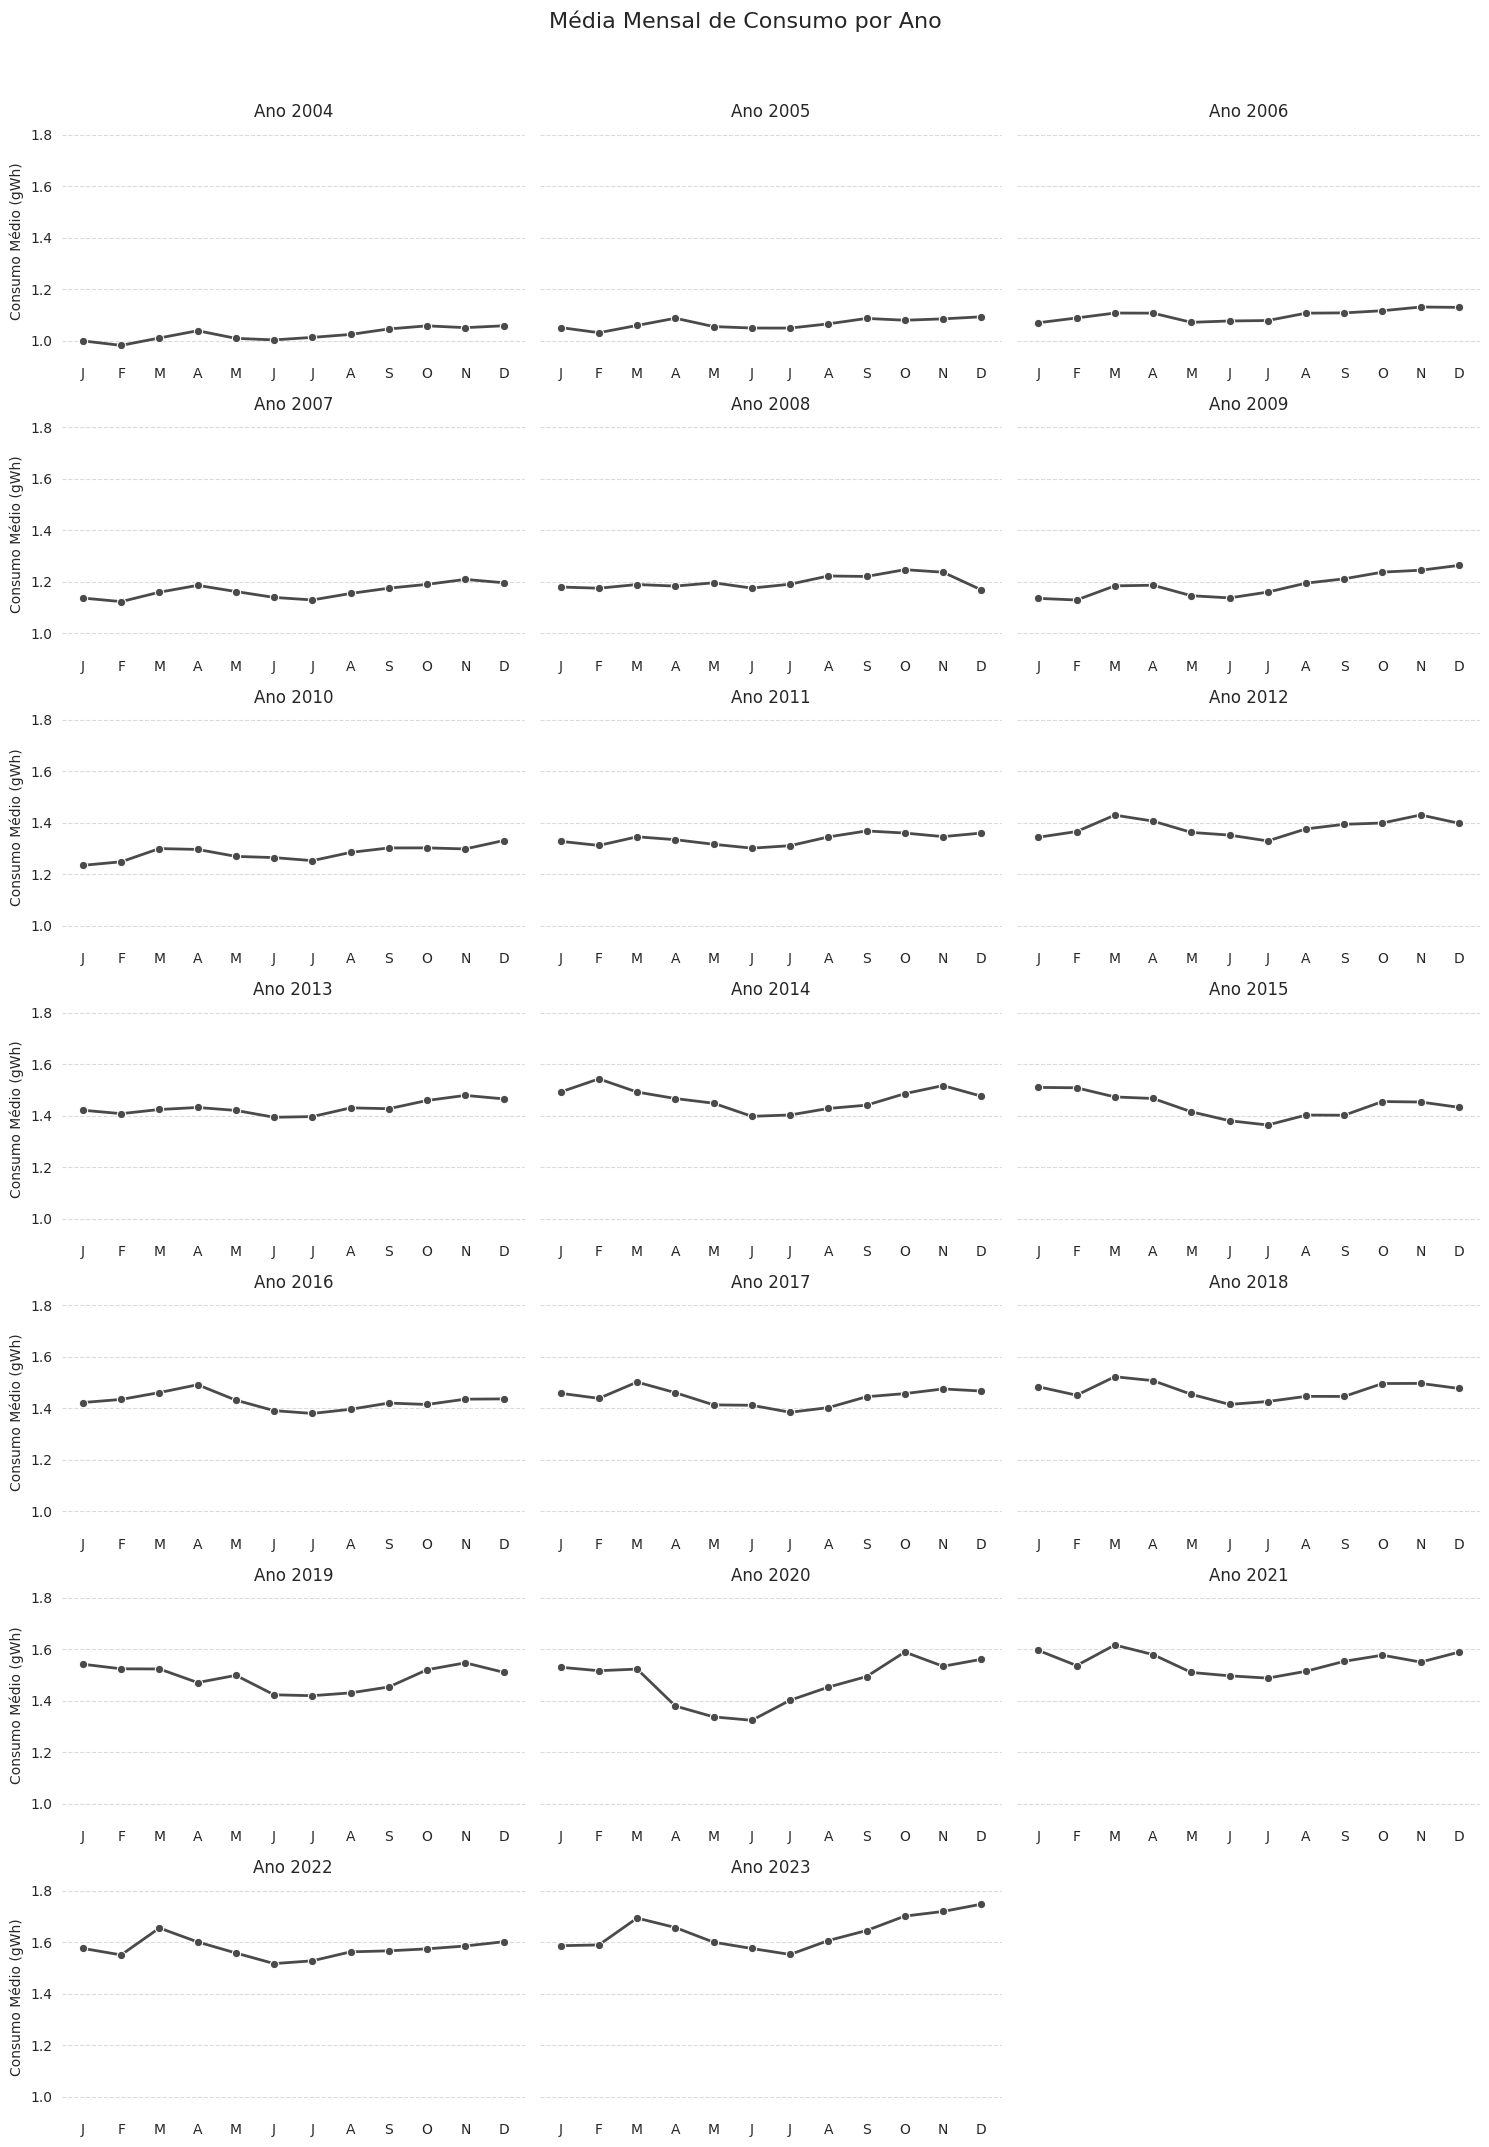

In [70]:
criar_lineplot_multifacetado(df, n_colunas=3)

Com esse gráfico podemos ver que março e abril geralmente são meses com consumo elevado e que a diferença entre os meses de inverno e verão começam a ser mais visíveis a partir de 2014. Será que, para um consumo mais acentuado nos meses quentes em relação aos meses frios, as pessoas tiveram mais acesso a ventiladores e ares-condicionado a patir desse ano? Em 2020 há uma queda grande no consumo muito próxima aos meses que começaram a vigorar as restrições da pandemia de Covid-19.

## 9. Há uma sazonalidade mais acentuada nos estados do sul?

Para responder essa pergunta, vamos precisar juntar as duas bases con um join.

In [71]:
consumo_sul = df.merge(df_estados, on='sigla_uf')

In [72]:
consumo_sul = consumo_sul[consumo_sul['regiao'] == 'Sul']

In [73]:
consumo_sul

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,gWh,estado,regiao
2,2004,1,PR,Total,NaN,1596274,1.596274,Paraná,Sul
3,2004,1,RS,Total,NaN,1780912,1.780912,Rio Grande do Sul,Sul
23,2004,1,SC,Total,NaN,1132926,1.132926,Santa Catarina,Sul
29,2004,2,PR,Total,NaN,1635576,1.635576,Paraná,Sul
30,2004,2,RS,Total,NaN,1824346,1.824346,Rio Grande do Sul,Sul
...,...,...,...,...,...,...,...,...,...
38840,2023,11,SC,Residencial,2715527.0,552287,0.552287,Santa Catarina,Sul
38852,2023,11,RS,Residencial,4356193.0,811141,0.811141,Rio Grande do Sul,Sul
38858,2023,12,PR,Residencial,4351390.0,846141,0.846141,Paraná,Sul
38868,2023,12,RS,Residencial,4360128.0,945119,0.945119,Rio Grande do Sul,Sul


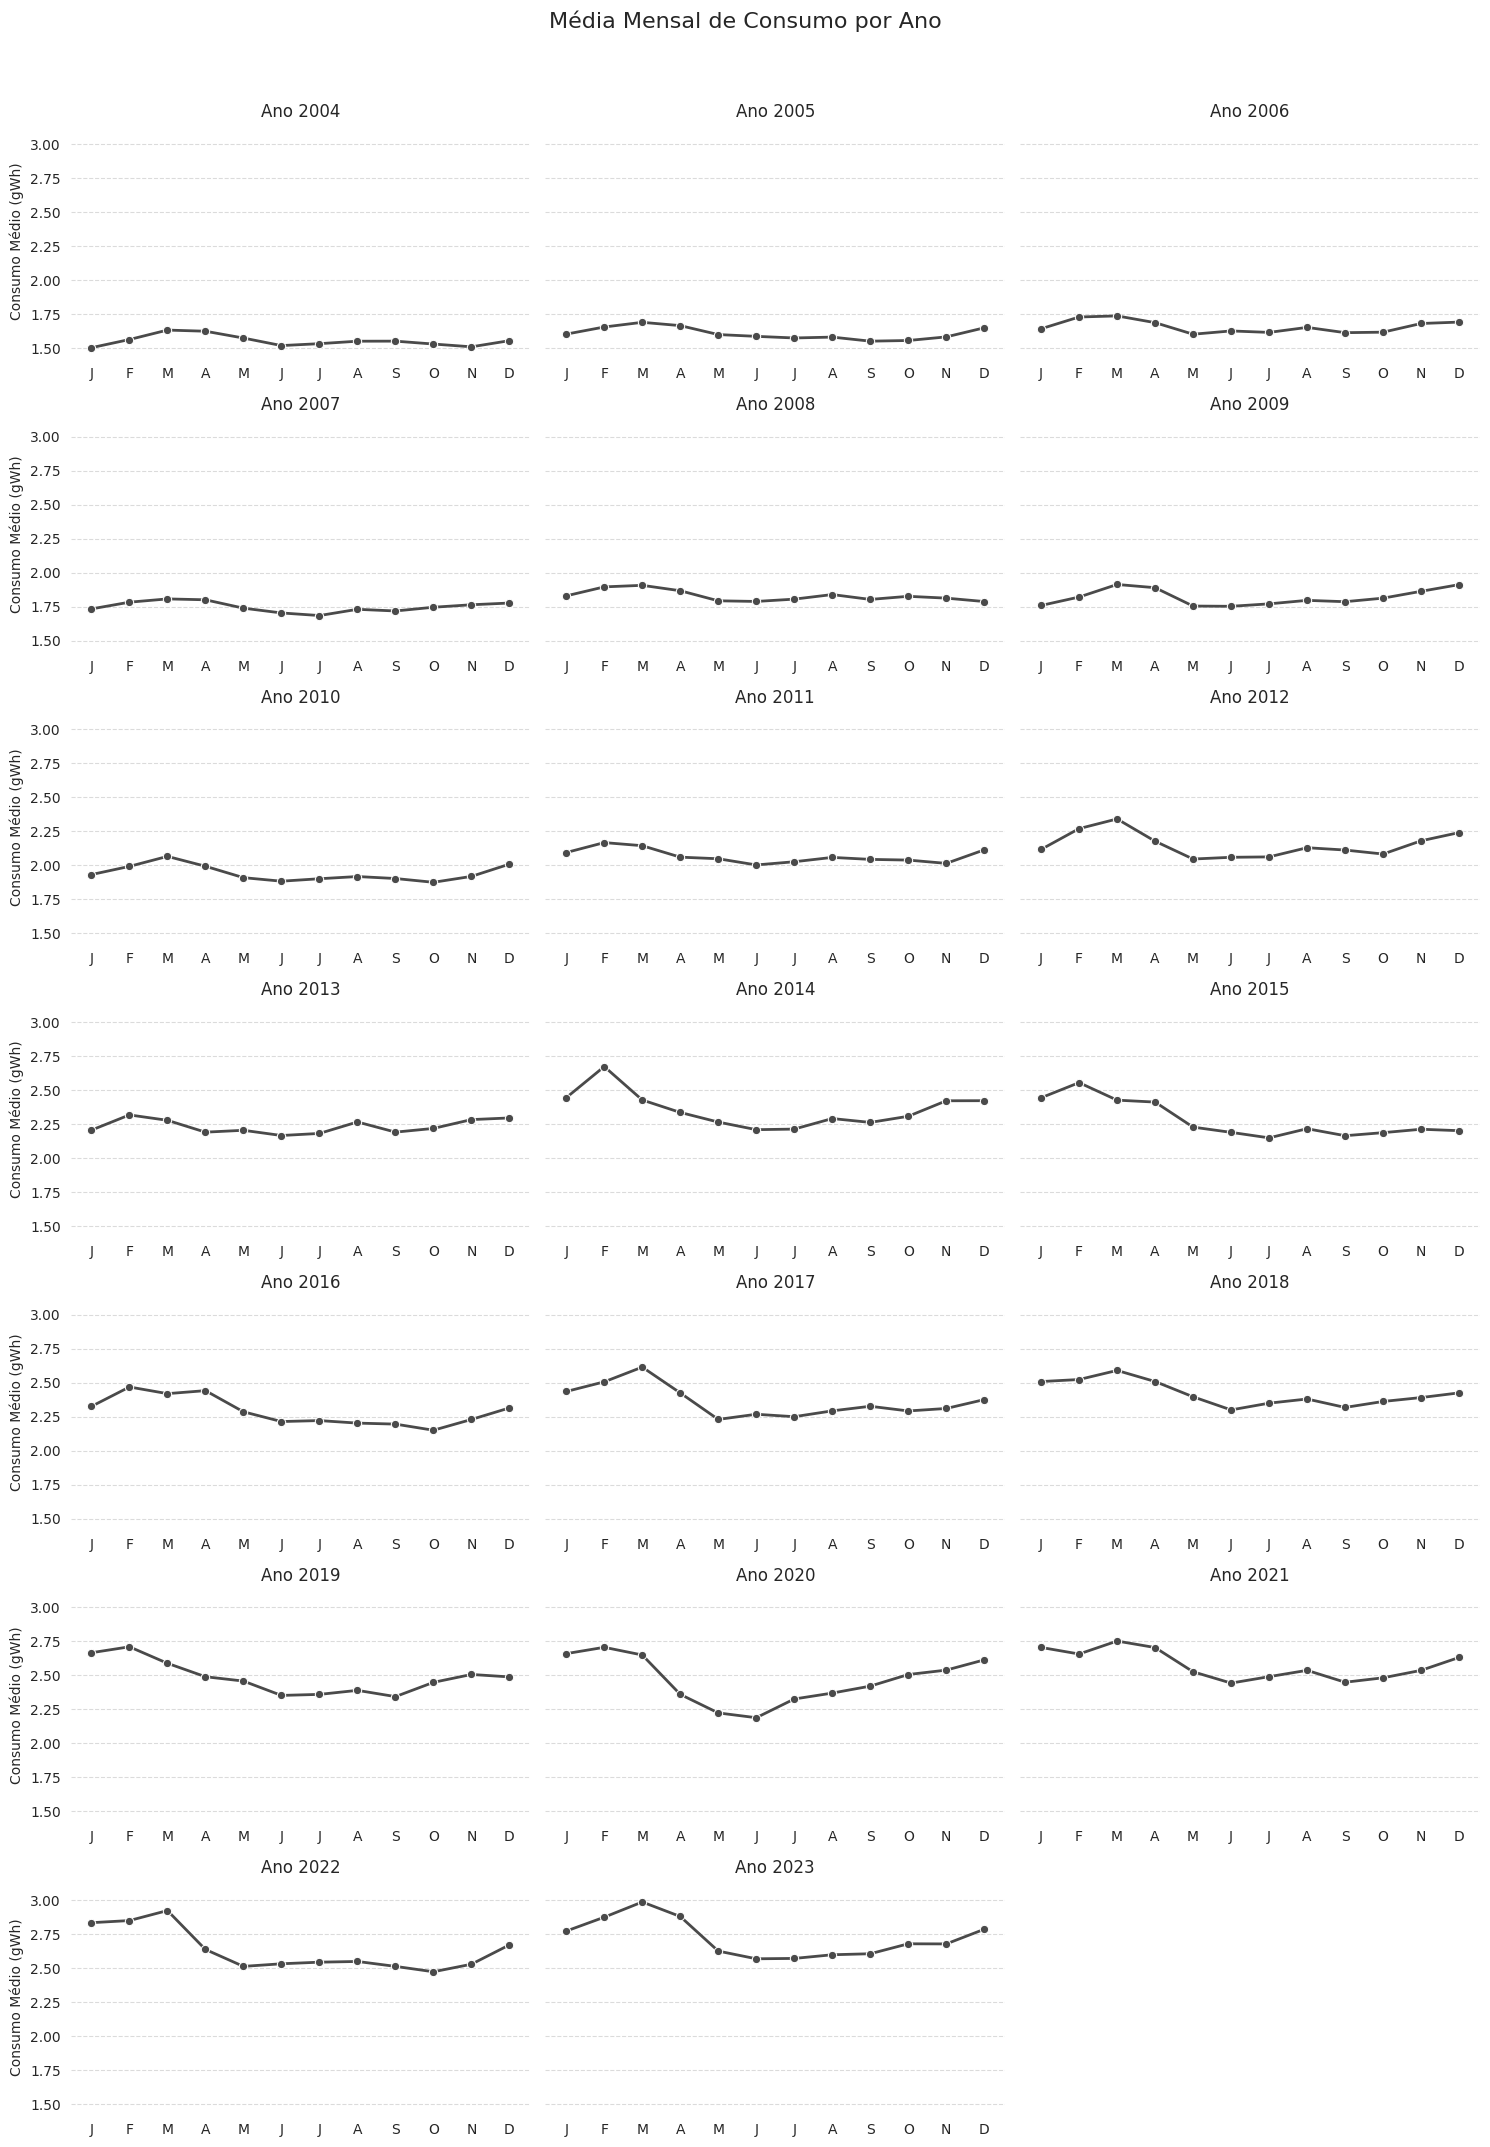

In [74]:
criar_lineplot_multifacetado(consumo_sul, n_colunas=3)

Embora o consumo seja mais elevado que a média total, não notei uma diferença muito acentuada entre os meses quentes e frios do sul comparado ao resto do país.

## 10. Tipos de consumo anual da série histórica (2004 - 2023)

In [75]:
filtro_tipos = ['Outros', 'Comercial', 'Industrial', 'Residencial']
tipos_consumo = df[df['tipo_consumo'].isin(filtro_tipos)]

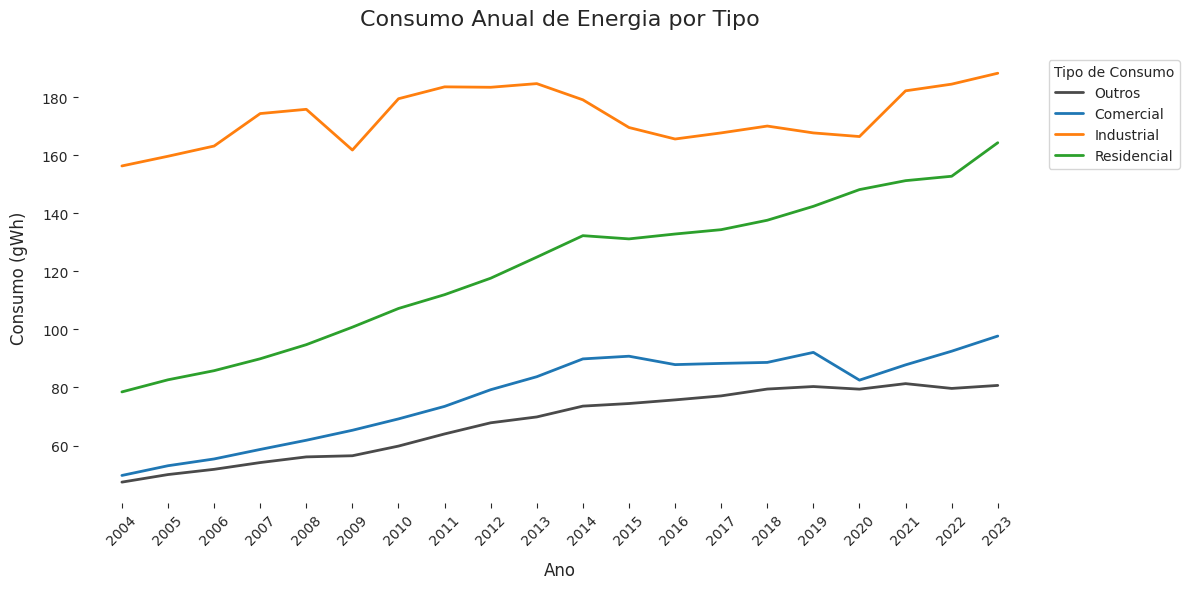

In [76]:
# Definir parâmetros
tipos_consumo = ['Outros', 'Comercial', 'Industrial', 'Residencial']
coluna_consumo = 'gWh'
ano_inicial = 2004
ano_final = 2024
caminho_salvar = '../imagens/consumo_anual_por_tipo.png'

# Filtrar os dados para os tipos de consumo especificados
df_filtrado = df[df['tipo_consumo'].isin(tipos_consumo)]

# Agrupar por ano e tipo de consumo
consumo_anual = df_filtrado.groupby(['ano', 'tipo_consumo'])[coluna_consumo].sum().unstack()

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

# Definir uma paleta de cores
cores = ['#4a4a4a', '#1f77b4', '#ff7f0e', '#2ca02c']

# Plotar o lineplot para cada tipo de consumo
for i, tipo in enumerate(tipos_consumo):
    sns.lineplot(x=consumo_anual.index, y=consumo_anual[tipo], 
                 color=cores[i], linewidth=2, label=tipo, ax=ax)

# Remover bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Configurar os ticks do eixo x
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(ano_inicial, ano_final))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Consumo Anual de Energia por Tipo', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel(f'Consumo ({coluna_consumo})', fontsize=12, labelpad=10)

# Adicionar legenda
plt.legend(title='Tipo de Consumo', loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig(caminho_salvar, format='png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Qual o consumo por região na série histórica (2004-2023)?

Vamos segmentar o consumo por região e descobrir o comportamento de consumo

In [77]:
# mesclando com o df_estados na coluna sigla_uf para trazer as regiões
df = df.merge(df_estados, on='sigla_uf')

In [78]:
# Definir parâmetros
regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']
caminho_salvar = '../imagens/consumo_anual_por_regiao.png'

In [79]:
# Filtrar os dados para o tipo de consumo 'Total' e as regiões especificadas
df_filtrado = df[(df['tipo_consumo'] == 'Total') & (df['regiao'].isin(regioes))]

# Agrupar por ano e região
consumo_anual_regiao = df_filtrado.groupby(['ano', 'regiao'])[coluna_consumo].sum().unstack()

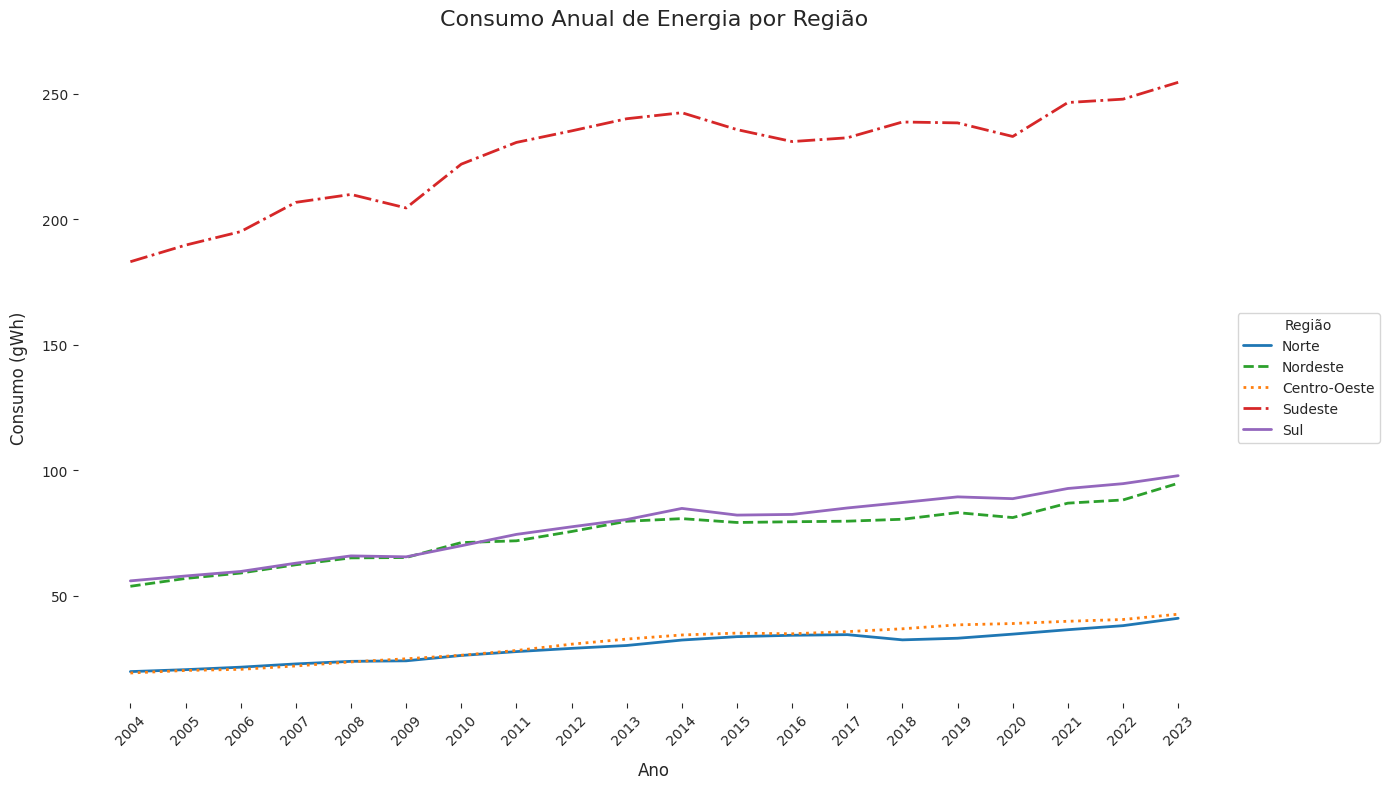

In [80]:
# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')

# Definir uma paleta de cores
cores = ['#1f77b4', '#2ca02c',  '#ff7f0e', '#d62728', '#9467bd']

# para dar mais legibilidades vamos usar cores e tipos de linha
estilos_linha = ['-', '--', ':', '-.', '-']

for i, regiao in enumerate(regioes):
    sns.lineplot(x=consumo_anual_regiao.index, y=consumo_anual_regiao[regiao], 
                 color=cores[i], linewidth=2, label=regiao, ax=ax,
                 linestyle=estilos_linha[i])

# Remover bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Remover ticks do eixo y
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Ajustar o intervalo do eixo x para mostrar todos os anos
plt.xticks(range(ano_inicial, ano_final))

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Configurar títulos e rótulos
plt.title('Consumo Anual de Energia por Região', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel(f'Consumo ({coluna_consumo})', fontsize=12, labelpad=10)

# Formatar o eixo y para usar separador de milhares
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adicionar legenda
plt.legend(title='Região', loc='center left', bbox_to_anchor=(1, 0.5))

# Ajustar o layout
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.savefig(caminho_salvar, format='png', dpi=300, bbox_inches='tight')
plt.show()

Podemos obsersvar que a região sudeste sempre esteve muito a frente das demais regiões em toda a série histórica, também que Nordeste e Sul tem um consumo parecido, da mesma forma que as regiões Centro-Oeste e Norte. Todas crescerem ao longo do tempo.

In [81]:
df[df['tipo_consumo'] == 'Total'].groupby('ano')['gWh'].sum()

ano
2004    331.865053
2005    345.336121
2006    356.129174
2007    377.030014
2008    388.472393
2009    384.306370
2010    415.667749
2011    433.015628
2012    448.126379
2013    463.142489
2014    474.823452
2015    465.987120
2016    462.068740
2017    467.474700
2018    475.764362
2019    482.515687
2020    476.568757
2021    502.565651
2022    509.440863
2023    531.012496
Name: gWh, dtype: float64